# USAD

## Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *

from usad import *

In [2]:
# NVIDIA의 GPU 상태 및 정보 확인하는 명령어
!nvidia-smi -L

GPU 0: NVIDIA GeForce MX450 (UUID: GPU-624ecbf3-6b5e-a90b-cd49-4dc02d928fa3)


In [3]:
device = get_default_device()

device

device(type='cpu')

## EDA - Data Pre-Processing

### Download dataset

In [4]:
!mkdir input

#normal period
#!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/

#anomalies
#!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/


# 에러 발생해서 그냥 다운받아서 넣었음.

���� ���͸� �Ǵ� ���� input��(��) �̹� �ֽ��ϴ�.


### Normal period

In [5]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)

normal

C:\Users\ygeun\AppData\Local\Temp\ipykernel_2252\458504778.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:30:00 PM,0,"124,3135",1,1,1,"251,9226","8,313446","312,7916",0,...,1,1,"9,100231",0,"3,3485","0,0002563035",1,1,1,Normal
1,22/12/2015 4:30:01 PM,0,"124,392",1,1,1,"251,9226","8,313446","312,7916",0,...,1,1,"9,100231",0,"3,3485","0,0002563035",1,1,1,Normal
2,22/12/2015 4:30:02 PM,0,"124,4705",1,1,1,"251,9226","8,313446","312,7916",0,...,1,1,"9,100231",0,"3,3485","0,0002563035",1,1,1,Normal
3,22/12/2015 4:30:03 PM,0,"124,6668",1,1,1,"251,9226","8,313446","312,7916",0,...,1,1,"9,100231",0,"3,3485","0,0002563035",1,1,1,Normal
4,22/12/2015 4:30:04 PM,0,"124,5098",1,1,1,"251,9226","8,313446","312,7916",0,...,1,1,"9,100231",0,"3,3485","0,0002563035",1,1,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494995,28/12/2015 9:59:55 AM,"2,460366","523,043",2,2,1,"262,0161","8,396437","328,5055","2,442316",...,2,1,"250,8171","1,778105","189,8552","0,0001281517",1,1,1,Normal
494996,28/12/2015 9:59:56 AM,"2,448836","522,9645",2,2,1,"262,0161","8,396437","328,5055","2,442316",...,2,1,"250,8171","1,778105","189,5027","0,0001281517",1,1,1,Normal
494997,28/12/2015 9:59:57 AM,"2,434744","522,886",2,2,1,"262,0161","8,396437","328,6337","2,444879",...,2,1,"250,8171","1,778105","189,5027","0,0001281517",1,1,1,Normal
494998,28/12/2015 9:59:58 AM,"2,428338","522,9252",2,2,1,"262,0161","8,396437","328,6337","2,445391",...,2,1,"250,8171","1,649953","189,5027","0,0001281517",1,1,1,Normal


In [6]:
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

(495000, 51)

In [7]:
# Transform all columns into float64
for i in list(normal): # list(normal)하면 컬럼명이 다 나옴
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

In [8]:
#Downsampling
down_rate = 5

# 나누면 0, 0, 0, 0, 0 5개가 되므로 이거 groupby로 묶고, 그것에 평균을 함
normal=normal.groupby(np.arange(len(normal.index)) // down_rate).mean()

normal.shape

(99000, 51)

#### Normalization

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [10]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005241,0.5,0.0,0.0,0.008695,0.075126,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.003821,0.5,0.0,0.0,0.008695,0.074071,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [11]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values] # False가 0으로, True가 1이 된다.  (y 값)
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1) # (x 값)
attack.shape

C:\Users\ygeun\AppData\Local\Temp\ipykernel_2252\549659368.py:2: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)


(449919, 51)

In [12]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

In [13]:
#Downsampling the attack data
attack=attack.groupby(np.arange(len(attack.index)) // down_rate).mean()
attack.shape

(89984, 51)

In [14]:
#Downsampling the labels
labels_down=[]

for i in range(len(labels)//down_rate):
    if labels[5*i:5*(i+1)].count(1.0):
        labels_down.append(1.0) #Attack
    else:
        labels_down.append(0.0) #Normal

#for the last few labels that are not within a full-length window
# 딱 나눠 떨어지지 않은 경우 처리
if labels[down_rate*(i+1):].count(1.0):
    labels_down.append(1.0) #Attack
else:
    labels_down.append(0.0) #Normal

print(len(labels_down))

89984


#### Normalization

In [15]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [16]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.917606,0.577402,1.0,1.0,0.0,0.49767,0.187329,0.064088,0.982593,1.0,...,0.975713,1.0,0.0,0.946163,0.484022,0.944197,0.000074,0.0,0.0,0.0
1,0.971946,0.579048,1.0,1.0,0.0,0.49767,0.186274,0.064088,0.982202,1.0,...,0.976686,1.0,0.0,0.945687,0.484022,0.943694,0.000074,0.0,0.0,0.0


### Windows

In [17]:
window_size=12 # 논문 기준 K 값

In [18]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(98988, 12, 51)

In [19]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(89972, 12, 51)

## Training

In [20]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 25
hidden_size = 40


w_size=windows_normal.shape[1]*windows_normal.shape[2] # 12 x 51 = 612 
z_size=windows_normal.shape[1]*hidden_size # 12 * 100 = 1200 (잠재벡터)


windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))] # np.floor: 소수 부분을 버리고 주어진 수보다 같거나 작은 가장 큰 정수로 내림
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [21]:
history = training(N_EPOCHS,model,train_loader,val_loader)

C:\Users\ygeun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


epoch [0], val_epoch_loss1: 0.0488, val_epoch_loss2: 0.0479
epoch [1], val_epoch_loss1: 0.0443, val_epoch_loss2: -0.0008
epoch [2], val_epoch_loss1: 0.0392, val_epoch_loss2: -0.0142
epoch [3], val_epoch_loss1: 0.0348, val_epoch_loss2: -0.0185
epoch [4], val_epoch_loss1: 0.0331, val_epoch_loss2: -0.0207
epoch [5], val_epoch_loss1: 0.0337, val_epoch_loss2: -0.0238
epoch [6], val_epoch_loss1: 0.0411, val_epoch_loss2: -0.0309
epoch [7], val_epoch_loss1: 0.0405, val_epoch_loss2: -0.0317
epoch [8], val_epoch_loss1: 0.0400, val_epoch_loss2: -0.0323
epoch [9], val_epoch_loss1: 0.0397, val_epoch_loss2: -0.0329
epoch [10], val_epoch_loss1: 0.0395, val_epoch_loss2: -0.0334
epoch [11], val_epoch_loss1: 0.0398, val_epoch_loss2: -0.0341
epoch [12], val_epoch_loss1: 0.0396, val_epoch_loss2: -0.0344
epoch [13], val_epoch_loss1: 0.0394, val_epoch_loss2: -0.0346
epoch [14], val_epoch_loss1: 0.0394, val_epoch_loss2: -0.0350
epoch [15], val_epoch_loss1: 0.0395, val_epoch_loss2: -0.0353
epoch [16], val_epo

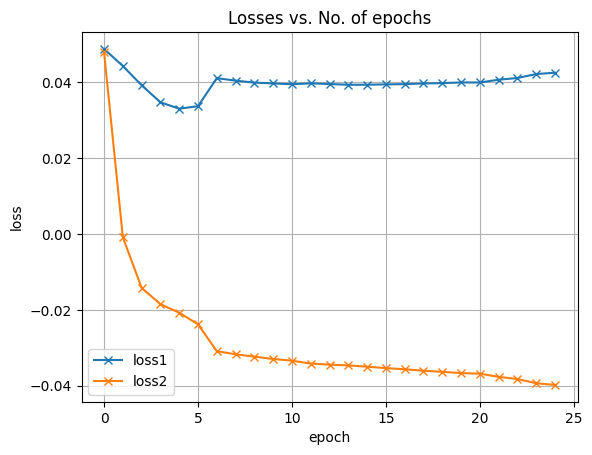

In [22]:
plot_history(history)

In [23]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model_SWaT.pth")

Another way to save the model

In [24]:
import pickle

filename = 'usad_model_SWaT.sav'
pickle.dump(model, open(filename, 'wb'))

In [25]:
loaded_model = pickle.load(open(filename, 'rb'))

## Testing

In [26]:
checkpoint = torch.load("model_SWaT.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [27]:
training_scores_list = training_scores(model,train_loader,val_loader)

In [28]:
training_scores_concat=np.concatenate([torch.stack(training_scores_list[:-1]).flatten().detach().cpu().numpy(),
                            training_scores_list[-1].flatten().detach().cpu().numpy()])

In [29]:

print(training_scores_concat)

[0.3315936  0.3316108  0.33162096 ... 0.00956355 0.00957111 0.00955731]


In [30]:
min(training_scores_concat)

0.00771211

In [31]:

results=training_scores(model, test_loader) # testing

In [32]:
print(results)

[tensor([0.0094, 0.0095, 0.0095,  ..., 0.0112, 0.0112, 0.0111],
       grad_fn=<AddBackward0>), tensor([0.0111, 0.0112, 0.0112,  ..., 0.0114, 0.0115, 0.0114],
       grad_fn=<AddBackward0>), tensor([0.0114, 0.0113, 0.0114,  ..., 0.0838, 0.0837, 0.0837],
       grad_fn=<AddBackward0>), tensor([0.0837, 0.0837, 0.0837,  ..., 0.0775, 0.0775, 0.0774],
       grad_fn=<AddBackward0>), tensor([0.0773, 0.0774, 0.0775,  ..., 0.1721, 0.1696, 0.1665],
       grad_fn=<AddBackward0>), tensor([0.1639, 0.1602, 0.1555,  ..., 0.6389, 0.6389, 0.6387],
       grad_fn=<AddBackward0>), tensor([0.6386, 0.6385, 0.6385,  ..., 0.3801, 0.3768, 0.3725],
       grad_fn=<AddBackward0>), tensor([0.3683, 0.3656, 0.3638,  ..., 0.3866, 0.3867, 0.3867],
       grad_fn=<AddBackward0>), tensor([0.3869, 0.3869, 0.3870,  ..., 0.3770, 0.3769, 0.3768],
       grad_fn=<AddBackward0>), tensor([0.3768, 0.3768, 0.3767,  ..., 0.4635, 0.4635, 0.4635],
       grad_fn=<AddBackward0>), tensor([0.4635, 0.4635, 0.4635,  ..., 0.4399, 0.4

In [33]:

windows_labels=[]
for i in range(len(labels_down)-window_size):
    windows_labels.append(list(np.int_(labels_down[i:i+window_size])))

In [34]:

y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [35]:

y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                            results[-1].flatten().detach().cpu().numpy()])

In [ ]:

results_threshold=testing_threshold(model,test_loader, alpha=.5, beta=.5, contamination=0.10)

In [ ]:

results_threshold

0.45086807

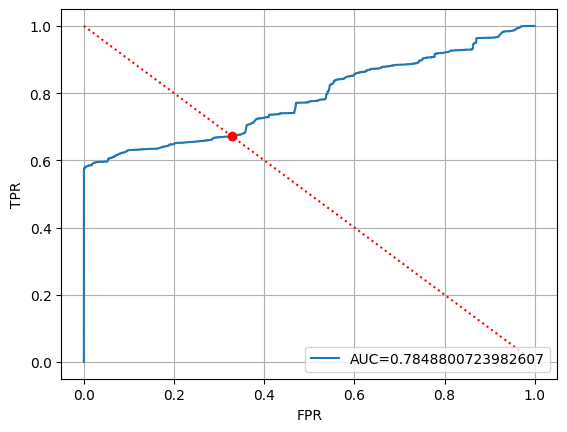

In [ ]:
threshold=ROC(y_test,y_pred)

In [ ]:

threshold=results_threshold # Decide on your own threshold
y_pred_label = [1.0 if (score > threshold) else 0 for score in y_pred ]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
prec=precision_score(y_test,y_pred_label,pos_label=1)
recall=recall_score(y_test,y_pred_label,pos_label=1)
f1=f1_score(y_test,y_pred_label,pos_label=1)
print('precision=',prec)
print('recall=',recall)
print('f1=',f1)


precision= 0.7483605646326553
recall= 0.5941581362513236
f1= 0.6624034630331054
